# Transfer learning example: fine tuning DistilBERT on the banking77 dataset for classification using keras, investigating the effect of changing the distribution of the training dataset
- Exploration of Banking77 dataset; is it balanced?
- Experimenting with a downsampled version of the dataset to get ballpark model architecture/learning rates. Visualise the training process and evaluate the trained model
- Do the same for the original dataset to see how a larger but imbalanced dataset compares. Do the same again for an upsampled version of the dataset to see if better accuracy can be achieved
- Motivation: we have no clue what the distribution of the test dataset is, perhaps it follows the distribution of the training set, perhaps it is uniformly distributed, perhaps a completely different distribution. The fact is that we do not know, so we hope a model fitted on a perfectly balanced dataset might be the most versatile/most likely to score a high accuracy on the test dataset

### Installs necessary for google colab

In [32]:
!pip install datasets
!pip install transformers

### Load Banking77 Dataset

- Banking77 dataset is found on huggingface

In [33]:
import pandas as pd
from datasets import load_dataset

all_data = load_dataset('banking77')
train_data, test_data = pd.DataFrame(all_data['train']), pd.DataFrame(all_data['test'])

Using custom data configuration default
Reusing dataset banking77 (/root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

### Data stored in following way

In [34]:
print(train_data.head())

                                                text  label
0                     I am still waiting on my card?     11
1  What can I do if my card still hasn't arrived ...     11
2  I have been waiting over a week. Is the card s...     11
3  Can I track my card while it is in the process...     11
4  How do I know if I will get my card, or if it ...     11


### Explore the Data
- Is it balanced or imbalanced?

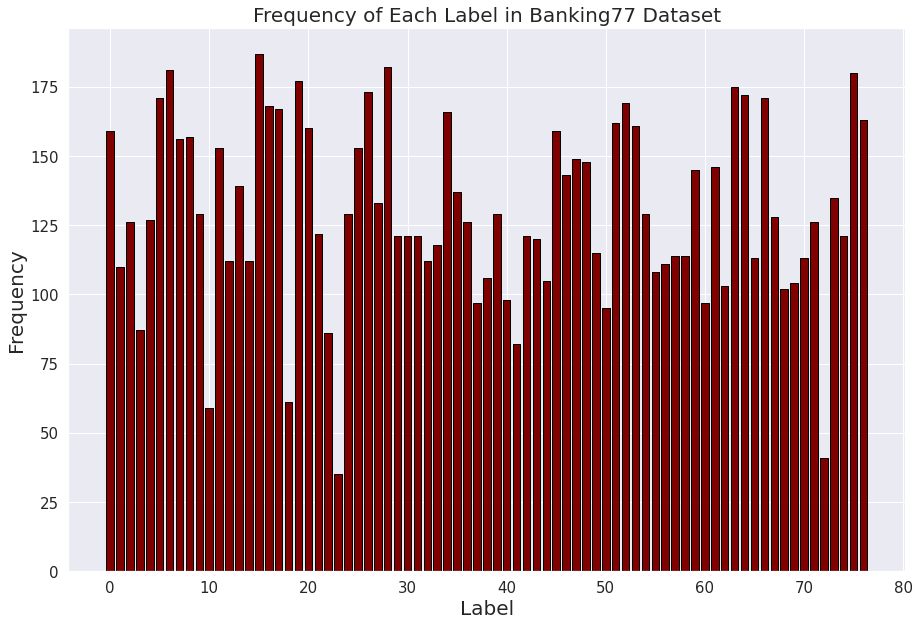

In [35]:
import matplotlib.pyplot as plt

label_counts = list(pd.DataFrame(train_data['label'].value_counts()).sort_index()['label'])
labels = range(0, 77)

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.bar(labels, label_counts, width=0.76, color='maroon', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Banking77 Dataset')
plt.show()

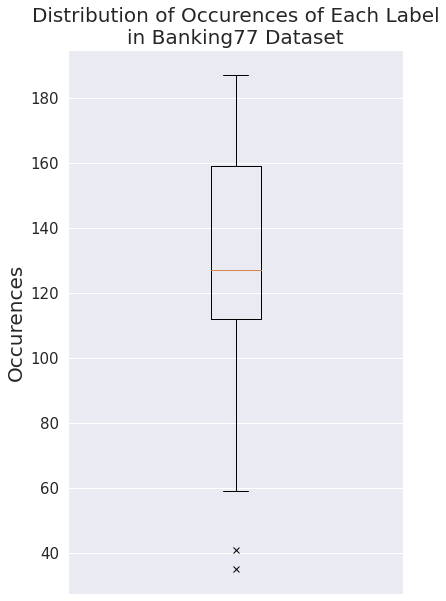

In [36]:
plt.rcParams['figure.figsize'] = [6, 10]
plt.title('Distribution of Occurences of Each Label\nin Banking77 Dataset')
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Occurences')
plt.boxplot(label_counts, sym='x')
plt.show()

### Verdict

- Data clearly imbalanced, with outliers

### Downsample the Dataset

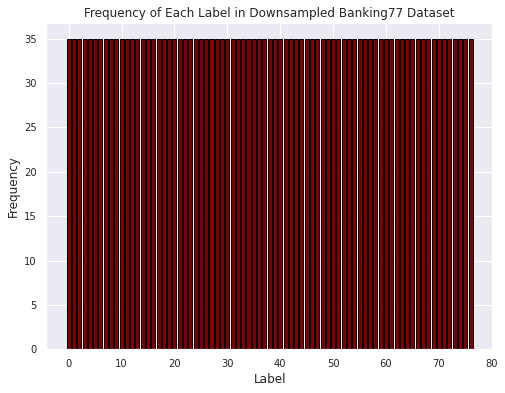

In [37]:
def downsample(tr_data):
    """
    any label with number of occurences in banking77 dataset more than that of
    the label with the least occurences will have occurences truncated so that
    every lable has the same nunmber of occurences with no duplicate data
    """
    min_occ = min(list(pd.DataFrame(tr_data['label'].value_counts()).sort_index()['label']))   # number of times the least frequent label appears
    ds_tr_data = pd.DataFrame({'text': [], 'label': []})
    for i in range(77):
        ds_tr_data = ds_tr_data.append(tr_data.loc[tr_data['label'] == i].head(min_occ))   # append the head (of length min_occ) of each dataframe comprising only rows of the same label to a new dataframe
    ds_tr_data.label = ds_tr_data.label.astype(int)
    return ds_tr_data

ds_train = downsample(train_data).sample(frac=1, random_state=10)
# shuffle the dataset, use seed of 10 for reproducibility. Shuffling occurs during .fit(), but this is a double check

label_counts = list(pd.DataFrame(ds_train['label'].value_counts()).sort_index()['label'])
labels = range(0, 77)

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.bar(labels, label_counts, width=0.76, color='maroon', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Downsampled Banking77 Dataset')
plt.show()

### Set Up Testing Model on Downsampled Dataset
- One 77 neuron layer on top of distilbert with no dropout 
- Found more complex architectures achieved lower accuracy

In [38]:
import tensorflow as tf
from transformers import TFDistilBertModel

"""     Set up DistilBERT part of the model     """

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# get distilbert 

input_ids = tf.keras.Input(shape=(98,), name='input_token', dtype='int32')
input_masks = tf.keras.Input(shape=(98,), name='masked_token', dtype='int32')
# configure inputs

dbert_layer = dbert_model(input_ids, attention_mask=input_masks)[0][:,0,:]
# output layer of distilbert to be input to the neural network on top

"""     Set up neural network part of model     """      

output_layer = tf.keras.layers.Dense(
    77, 
    activation='softmax', 
    kernel_regularizer='l2'
    )(dbert_layer)
# output layer, fully connected, with 77 neurons since there are 77 output classes

"""     Apply freezing and compile     """

test_model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=output_layer)

for layer in test_model.layers[:2]:
    layer.trainable = False

sched_lr = tf.keras.optimizers.schedules.CosineDecay(     # learning rate schedule for Adam optimizer
      initial_learning_rate=0.0001,   # initial learning rate, quite large
      decay_steps=81*10,    # roughly 80 steps per epoch, want it to decay over 10 epochs, so decay over 80*10 steps   
      alpha=0.01      # want minimum learning rate to be alpha*initial_learning_rate
      )

sched_opt = tf.keras.optimizers.Adam(learning_rate=sched_lr)

test_model.compile(
    optimizer=sched_opt, 
    loss='categorical_crossentropy', # categorical crossentropy is to be minimised since we have 77 categories to classify into
    metrics=['categorical_accuracy']  # again, this is a categorical classification task
    )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Test Model Architecture

In [39]:
print(test_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 98)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 98)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_3 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 768)          0           tf_distil_bert_model_3[0][0

### Reconfigure data to make it suitable for DistilBERT input
- Tokenize the text data
- One hot encode the label data

In [40]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

"""     Tokenize text     """

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

ds_train_text = tokenizer(
    list(ds_train['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

test_text = tokenizer(
    list(test_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

"""     One hot encode the labels     """

ds_train_labels = tf.keras.utils.to_categorical(ds_train['label'])   # pd.get_dummies() also works
test_labels = tf.keras.utils.to_categorical(test_data['label'])

# if using sparse categorical crossentropy, uncomment the following
# train_labels = train_data['label']
# test_labels = test_data['label']


### Train the Test Model
- Lots of trial and error here - to get a feel for things and debug while using the smaller downsampled dataset so that everything is quicker

In [41]:
history = test_model.fit(
    [ds_train_text['input_ids'], ds_train_text['attention_mask']], 
    ds_train_labels,
    batch_size=30,   # number of input sentences between updating the weights
    epochs=10,   # probs fiddle with this to experiment
    verbose=2,  # want to see more information
    validation_split=0.1    # seems about right
)

Epoch 1/10
81/81 - 31s - loss: 3.7562 - categorical_accuracy: 0.4330 - val_loss: 2.2650 - val_categorical_accuracy: 0.7519
Epoch 2/10
81/81 - 24s - loss: 1.8126 - categorical_accuracy: 0.8664 - val_loss: 1.8012 - val_categorical_accuracy: 0.8407
Epoch 3/10
81/81 - 24s - loss: 1.3969 - categorical_accuracy: 0.9753 - val_loss: 1.6112 - val_categorical_accuracy: 0.8852
Epoch 4/10
81/81 - 24s - loss: 1.2615 - categorical_accuracy: 0.9938 - val_loss: 1.5477 - val_categorical_accuracy: 0.9074
Epoch 5/10
81/81 - 25s - loss: 1.1879 - categorical_accuracy: 0.9971 - val_loss: 1.4823 - val_categorical_accuracy: 0.9111
Epoch 6/10
81/81 - 25s - loss: 1.1371 - categorical_accuracy: 0.9996 - val_loss: 1.4443 - val_categorical_accuracy: 0.9074
Epoch 7/10
81/81 - 25s - loss: 1.1023 - categorical_accuracy: 1.0000 - val_loss: 1.4170 - val_categorical_accuracy: 0.9074
Epoch 8/10
81/81 - 25s - loss: 1.0814 - categorical_accuracy: 1.0000 - val_loss: 1.4065 - val_categorical_accuracy: 0.9074
Epoch 9/10
81/81

### Visualise the Training Process
- Plot Training and Validation Loss
- Plot Training and Validation Accuracy

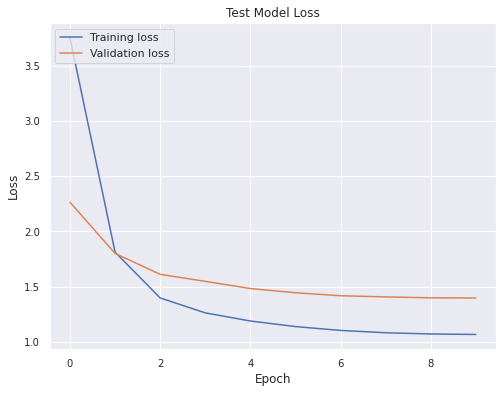

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Test Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

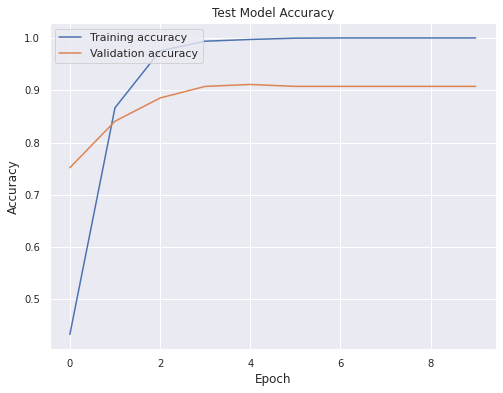

In [43]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Test Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

### Evaluate the Model Trained on Downsampled Dataset
- Get Confusion Matrix
- Get Accuracy

In [44]:
pred = test_model.predict([test_text['input_ids'], test_text['attention_mask']])

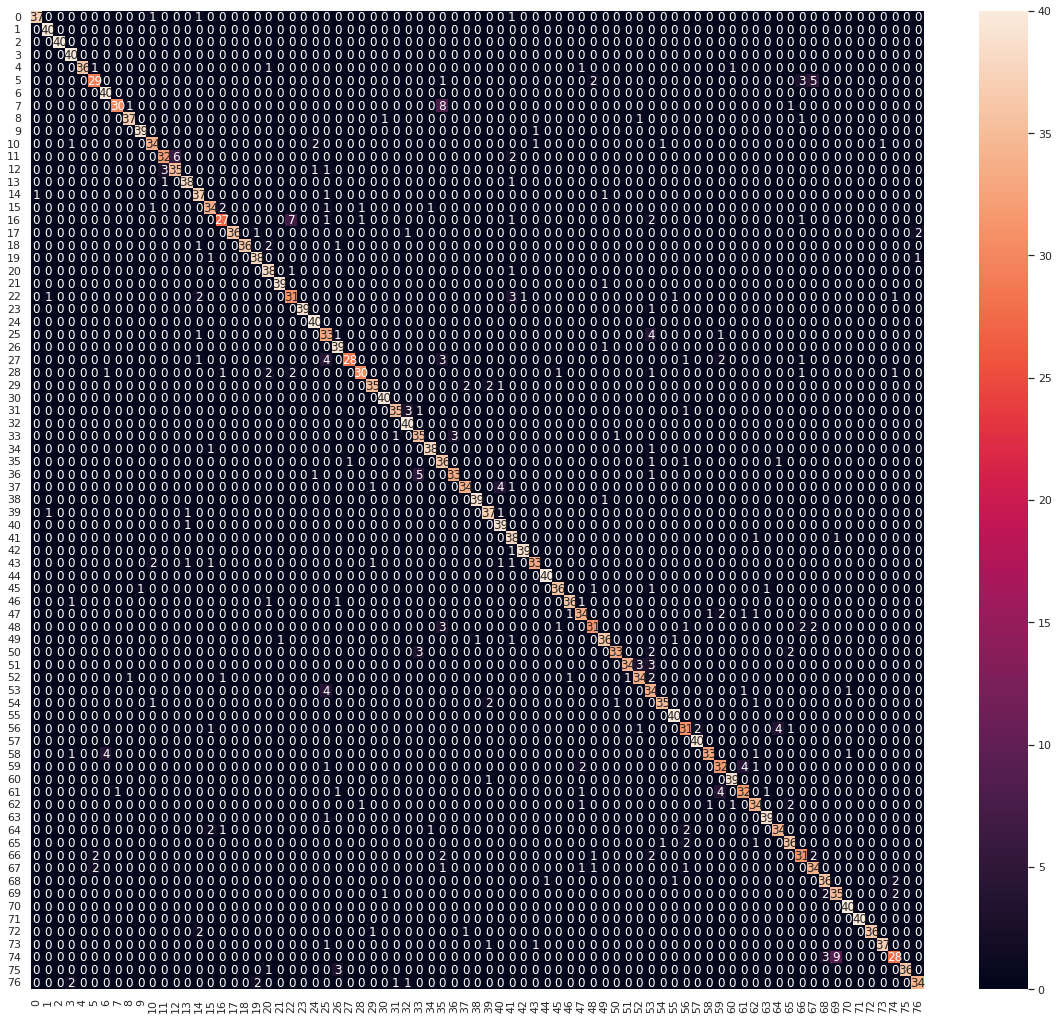

In [45]:
import seaborn as sns

cf_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(cf_matrix, annot=True)

In [46]:
eval = test_model.evaluate([test_text['input_ids'], test_text['attention_mask']], test_labels, verbose=2)

97/97 - 12s - loss: 1.4855 - categorical_accuracy: 0.8906


## Test Model Summary
After much experimenting, this combination of number of layers on top of DistilBERT (1), number of epochs (40), amount of freezing (up to the penultimate layer of DistilBERT), and learning rate schedule (cosine decay, no restarts) achieved the best accuracy for the downsampled dataset: 44.5% accuracy. This looks small, but it is important to remember that the dataset is finely grained, and that with 77 classes a random classifier would have 1.30% accuracy.

# Train & Test the Model on the Original, Unbalanced Dataset

Run following code if only want to run this half of notebook

In [47]:
!pip install datasets
!pip install transformers

import pandas as pd
from datasets import load_dataset

all_data = load_dataset('banking77')
train_data, test_data = pd.DataFrame(all_data['train']), pd.DataFrame(all_data['test'])

Using custom data configuration default
Reusing dataset banking77 (/root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

### Set up Model for Normal Dataset

In [48]:
import tensorflow as tf
from transformers import TFDistilBertModel

train_data = train_data.sample(frac=1, random_state=10)

"""     Set up DistilBERT part of the model     """

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# get distilbert 

input_ids = tf.keras.Input(shape=(98,), name='input_token', dtype='int32')
input_masks = tf.keras.Input(shape=(98,), name='masked_token', dtype='int32')
# configure inputs

dbert_layer = dbert_model(input_ids, attention_mask=input_masks)[0][:,0,:]
# output layer of distilbert to be input to the neural network on top

"""     Set up neural network part of model     """      

output_layer = tf.keras.layers.Dense(
    77, 
    activation='softmax', 
    kernel_regularizer='l2'
    )(dbert_layer)
# output layer, fully connected, with 77 neurons since there are 77 output classes

"""     Apply freezing, configure learning rate (schedule) and compile     """

regular_model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=output_layer)

for layer in regular_model.layers[:2]:
    layer.trainable = False

sched_lr = tf.keras.optimizers.schedules.CosineDecay(     # learning rate schedule for Adam optimizer
      initial_learning_rate=0.0001,   # initial learning rate, quite large
      decay_steps=300*10,    # roughly 300 steps per epoch, want it to decay over 10 epochs, so decay over 300*10 steps   
      alpha=0.01      # want minimum learning rate to be alpha*initial_learning_rate
      )

sched_opt = tf.keras.optimizers.Adam(learning_rate=sched_lr)    # 0.0001

regular_model.compile(
    optimizer=sched_opt, 
    loss='categorical_crossentropy', # categorical crossentropy is to be minimised since we have 77 categories to classify into
    metrics=['categorical_accuracy']  # again, this is a categorical classification task
    )



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Tokenize/Encode Dataset

In [49]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

"""     Tokenize text     """

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_text = tokenizer(
    list(train_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

test_text = tokenizer(
    list(test_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

"""     One hot encode the labels     """

train_labels = tf.keras.utils.to_categorical(train_data['label'])   # pd.get_dummies() also works
test_labels = tf.keras.utils.to_categorical(test_data['label'])

# if using sparse categorical crossentropy, uncomment the following
# train_labels = train_data['label']
# test_labels = test_data['label']

### Train It!

In [50]:
history = regular_model.fit(
    [train_text['input_ids'], train_text['attention_mask']], 
    train_labels,
    batch_size=30,   # number of input sentences between updating the weights
    epochs=10,   # probs fiddle with this to experiment
    verbose=2,  # want to see more information
    validation_split=0.1    # seems about right
)

Epoch 1/10
301/301 - 98s - loss: 2.3940 - categorical_accuracy: 0.7225 - val_loss: 1.5716 - val_categorical_accuracy: 0.8851
Epoch 2/10
301/301 - 91s - loss: 1.3166 - categorical_accuracy: 0.9349 - val_loss: 1.3527 - val_categorical_accuracy: 0.8911
Epoch 3/10
301/301 - 91s - loss: 0.9971 - categorical_accuracy: 0.9699 - val_loss: 1.1928 - val_categorical_accuracy: 0.8941
Epoch 4/10
301/301 - 91s - loss: 0.7883 - categorical_accuracy: 0.9850 - val_loss: 0.9974 - val_categorical_accuracy: 0.9021
Epoch 5/10
301/301 - 91s - loss: 0.6197 - categorical_accuracy: 0.9970 - val_loss: 0.8951 - val_categorical_accuracy: 0.9131
Epoch 6/10
301/301 - 91s - loss: 0.5218 - categorical_accuracy: 0.9987 - val_loss: 0.8063 - val_categorical_accuracy: 0.9181
Epoch 7/10
301/301 - 91s - loss: 0.4597 - categorical_accuracy: 0.9991 - val_loss: 0.7597 - val_categorical_accuracy: 0.9141
Epoch 8/10
301/301 - 91s - loss: 0.4226 - categorical_accuracy: 0.9994 - val_loss: 0.7214 - val_categorical_accuracy: 0.9201


### Visualize Training for Regular Model

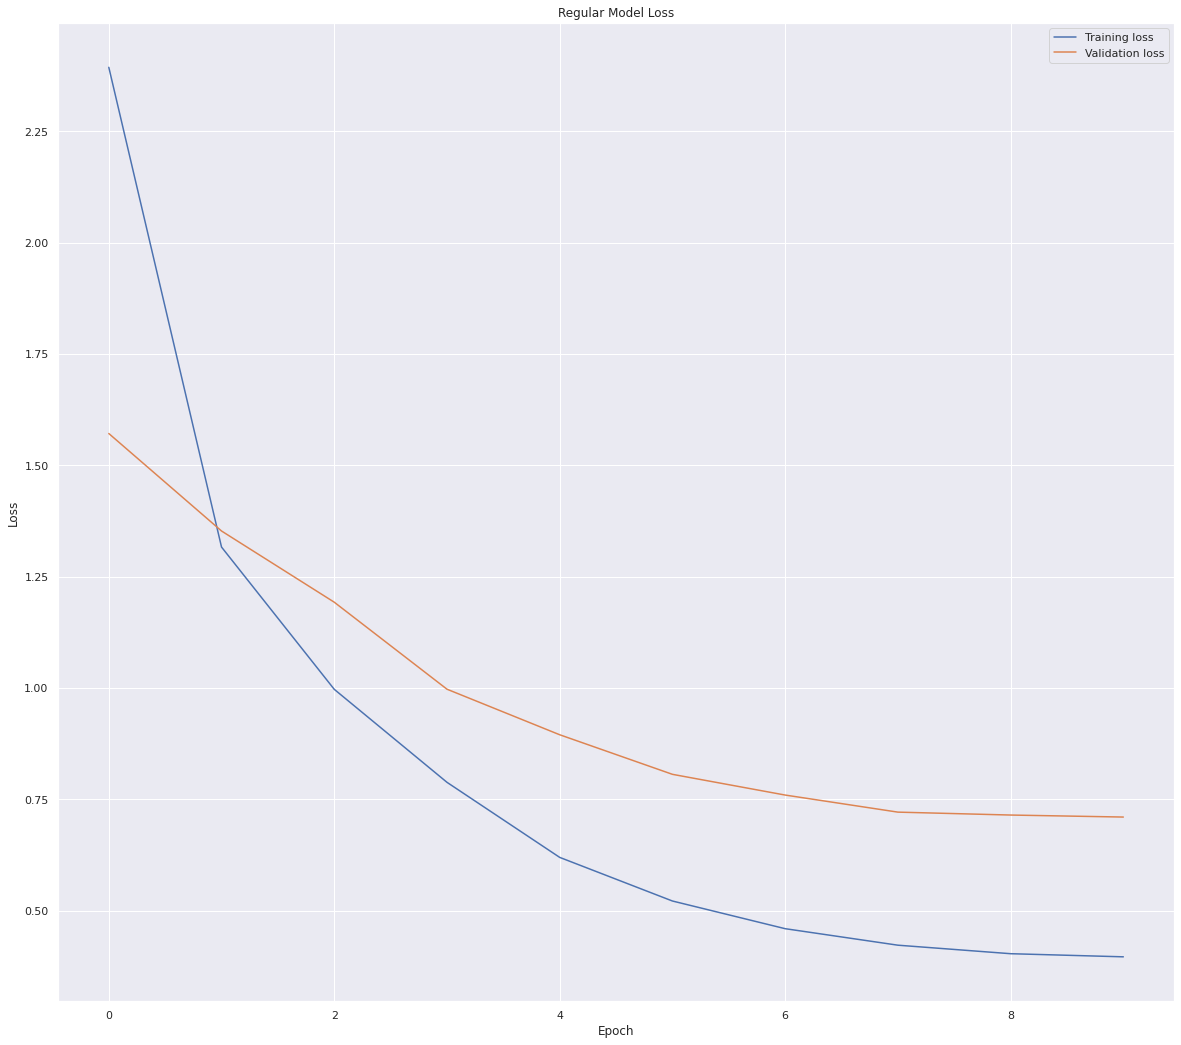

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Regular Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

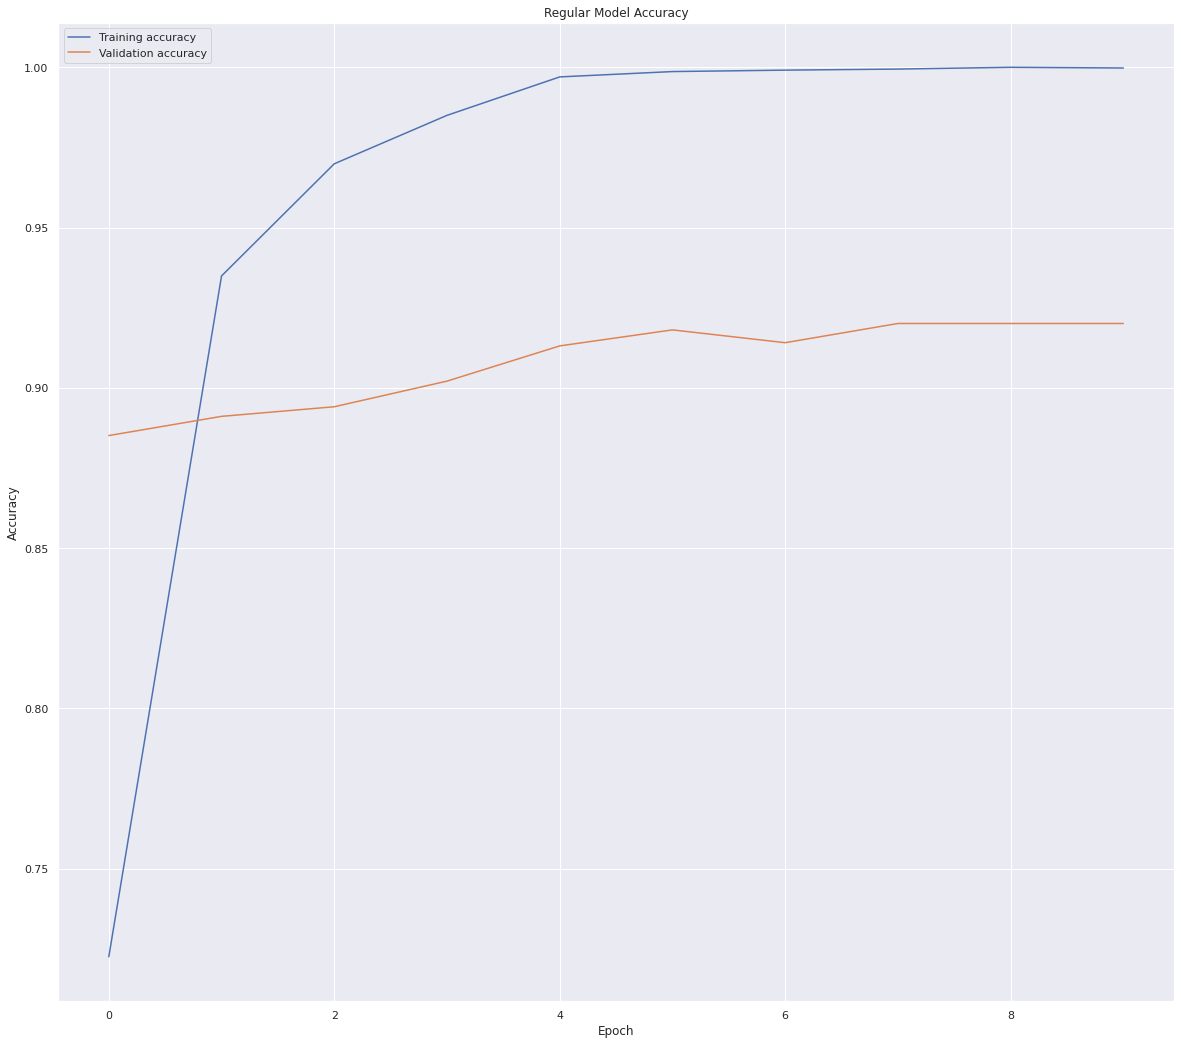

In [52]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Regular Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

### Evaluate the Model Trained on Regular Dataset
- Get Confusion Matrix
- Get Accuracy

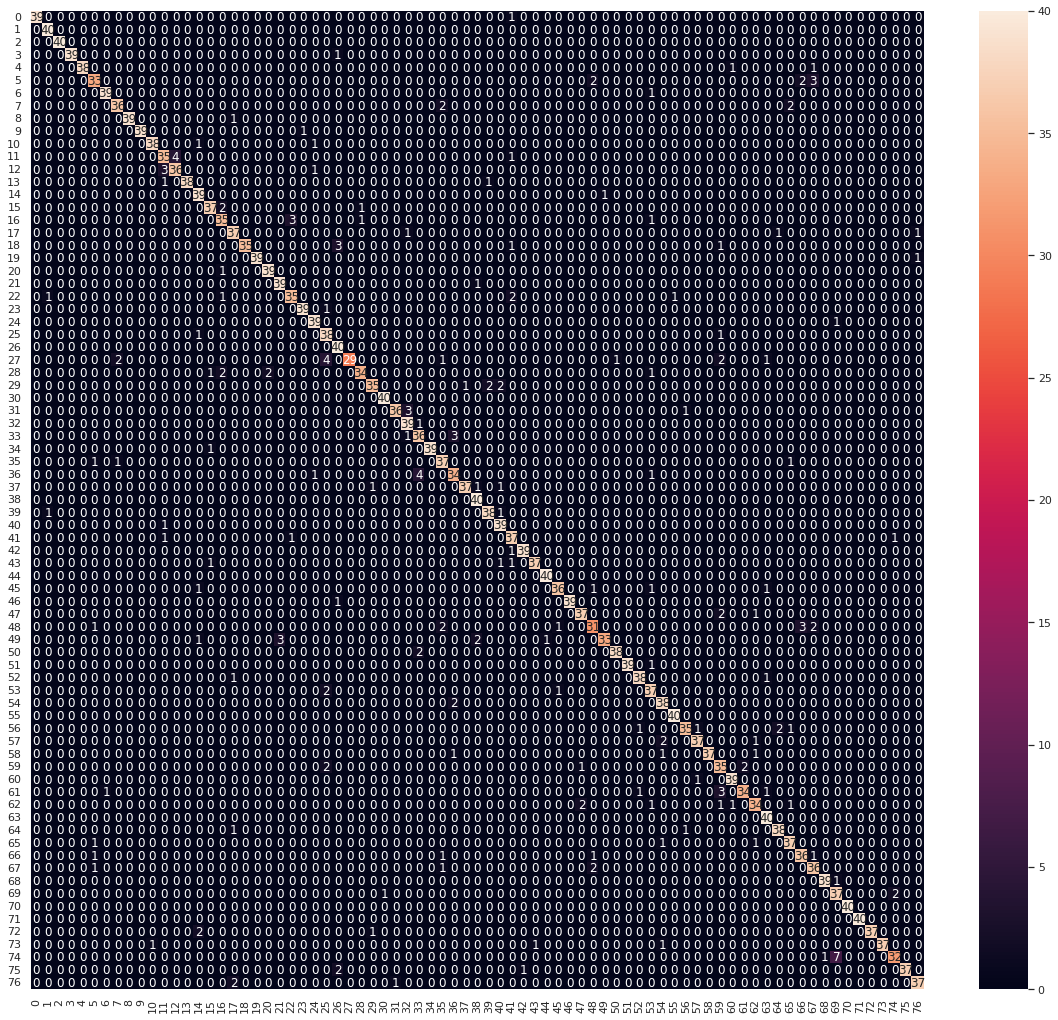

In [53]:
import seaborn as sns

pred = regular_model.predict([test_text['input_ids'], test_text['attention_mask']])
cf_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(cf_matrix, annot=True)

In [54]:
eval = regular_model.evaluate([test_text['input_ids'], test_text['attention_mask']], test_labels, verbose=2)

97/97 - 10s - loss: 0.6661 - categorical_accuracy: 0.9305


### Train and Evaluate a Model on an Upsampled Banking77 Dataset

Run following code to run this seperately from the rest of the notebook

In [55]:
!pip install datasets
!pip install transformers

import pandas as pd
from datasets import load_dataset

all_data = load_dataset('banking77')
train_data, test_data = pd.DataFrame(all_data['train']), pd.DataFrame(all_data['test'])

Using custom data configuration default
Reusing dataset banking77 (/root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
import numpy as np

def upsample(tr_data):
    """
    """
    max_occ= max(list(pd.DataFrame(tr_data['label'].value_counts()).sort_index()['label']))   # number of times the most frequent label appears
    us_tr_data = pd.DataFrame({'text': [], 'label': []})
    for i in range(77):
        occ_count = len(tr_data.loc[tr_data['label'] == i])
        j = 1
        while occ_count * j < max_occ - occ_count:
            j += 1
        for _ in range(j):
            us_tr_data = us_tr_data.append(tr_data.loc[tr_data['label'] == i])      # append the whole dataframe of occurences of a certain label as many times
        us_tr_data = us_tr_data.append(tr_data.loc[tr_data['label'] == i].head(max_occ - occ_count*j))
    us_tr_data.label = us_tr_data.label.astype(int)
    return us_tr_data
        
us_train = upsample(train_data).sample(frac=1, random_state=10)

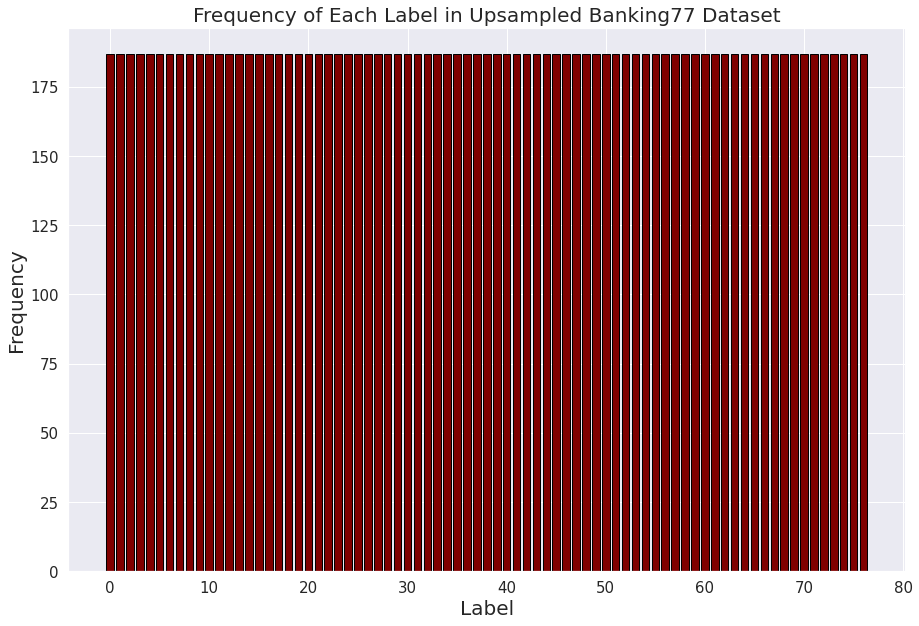

In [57]:
import matplotlib.pyplot as plt

label_counts = list(pd.DataFrame(us_train['label'].value_counts()).sort_index()['label'])
labels = range(0, 77)

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.bar(labels, label_counts, width=0.76, color='maroon', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Upsampled Banking77 Dataset')
plt.show()

In [58]:
import tensorflow as tf
from transformers import TFDistilBertModel

train_data = train_data.sample(frac=1, random_state=10)

"""     Set up DistilBERT part of the model     """

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# get distilbert 

input_ids = tf.keras.Input(shape=(98,), name='input_token', dtype='int32')
input_masks = tf.keras.Input(shape=(98,), name='masked_token', dtype='int32')
# configure inputs

dbert_layer = dbert_model(input_ids, attention_mask=input_masks)[0][:,0,:]
# output layer of distilbert to be input to the neural network on top

"""     Set up neural network part of model     """    

dropout = tf.keras.layers.Dropout(0.1)(dbert_layer)
# add some dropout for robustness

output_layer = tf.keras.layers.Dense(
    77, 
    activation='softmax', 
    kernel_regularizer='l2'
    )(dropout)
# output layer, fully connected, with 77 neurons since there are 77 output classes

"""     Apply freezing and compile     """

final_model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=output_layer)

for layer in final_model.layers[:2]:
    layer.trainable = False

sched_lr = tf.keras.optimizers.schedules.CosineDecay(     # learning rate schedule for Adam optimizer
      initial_learning_rate=0.0001,   # initial learning rate, quite large
      decay_steps=432*10,    # roughly 432 steps per epoch, want it to decay over 10 epochs 
      alpha=0.01      # want minimum learning rate to be alpha*initial_learning_rate
      )

sched_opt = tf.keras.optimizers.Adam(learning_rate=sched_lr)    # 0.0001

final_model.compile(
    optimizer=sched_opt, 
    loss='categorical_crossentropy', # categorical crossentropy is to be minimised since we have 77 categories to classify into
    metrics=['categorical_accuracy']  # again, this is a categorical classification task
    )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [59]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

"""     Tokenize text     """

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_text = tokenizer(
    list(us_train['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

test_text = tokenizer(
    list(us_train['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

"""     One hot encode the labels     """

train_labels = tf.keras.utils.to_categorical(us_train['label'])   # pd.get_dummies() also works
test_labels = tf.keras.utils.to_categorical(us_train['label'])

# if using sparse categorical crossentropy, uncomment the following
# train_labels = train_data['label']
# test_labels = test_data['label']

In [60]:
history = final_model.fit(
    [train_text['input_ids'], train_text['attention_mask']], 
    train_labels,
    batch_size=30,   # number of input sentences between updating the weights
    epochs=10,   # probs fiddle with this to experiment
    verbose=2,  # want to see more information
    validation_split=0.1    # seems about right
)

Epoch 1/10
432/432 - 138s - loss: 2.1627 - categorical_accuracy: 0.7704 - val_loss: 1.3688 - val_categorical_accuracy: 0.9243
Epoch 2/10
432/432 - 131s - loss: 1.1310 - categorical_accuracy: 0.9545 - val_loss: 1.0011 - val_categorical_accuracy: 0.9528
Epoch 3/10
432/432 - 131s - loss: 0.7842 - categorical_accuracy: 0.9819 - val_loss: 0.7350 - val_categorical_accuracy: 0.9625
Epoch 4/10
432/432 - 131s - loss: 0.5553 - categorical_accuracy: 0.9926 - val_loss: 0.5660 - val_categorical_accuracy: 0.9715
Epoch 5/10
432/432 - 132s - loss: 0.4200 - categorical_accuracy: 0.9954 - val_loss: 0.4568 - val_categorical_accuracy: 0.9715
Epoch 6/10
432/432 - 131s - loss: 0.3333 - categorical_accuracy: 0.9987 - val_loss: 0.3960 - val_categorical_accuracy: 0.9715
Epoch 7/10
432/432 - 131s - loss: 0.2866 - categorical_accuracy: 0.9992 - val_loss: 0.3648 - val_categorical_accuracy: 0.9729
Epoch 8/10
432/432 - 132s - loss: 0.2615 - categorical_accuracy: 0.9998 - val_loss: 0.3479 - val_categorical_accuracy:

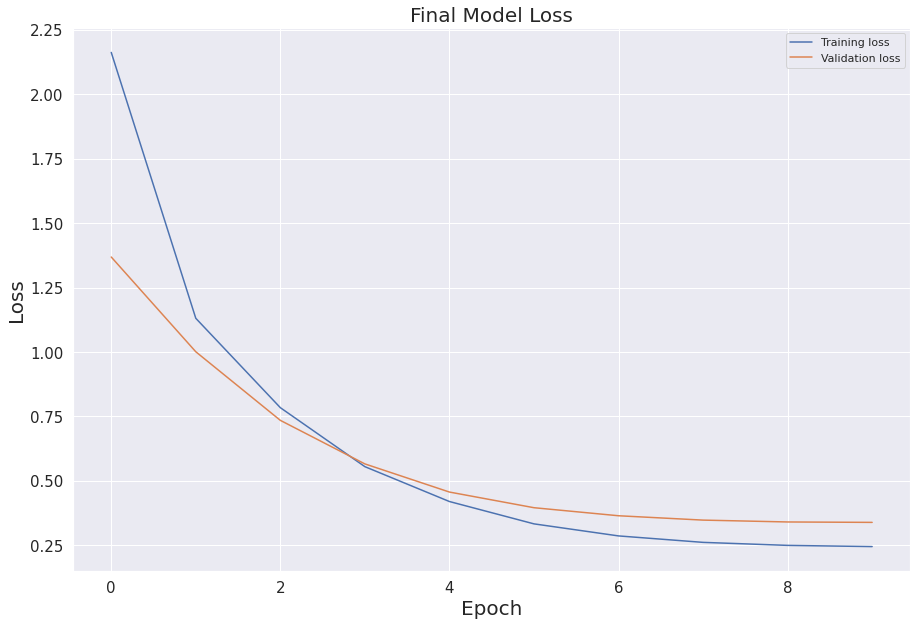

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

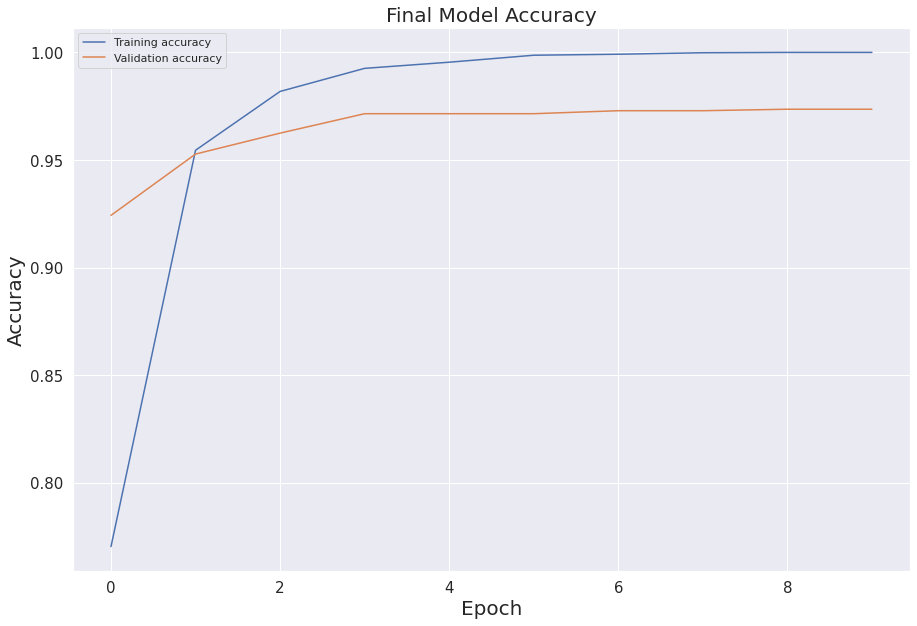

In [62]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

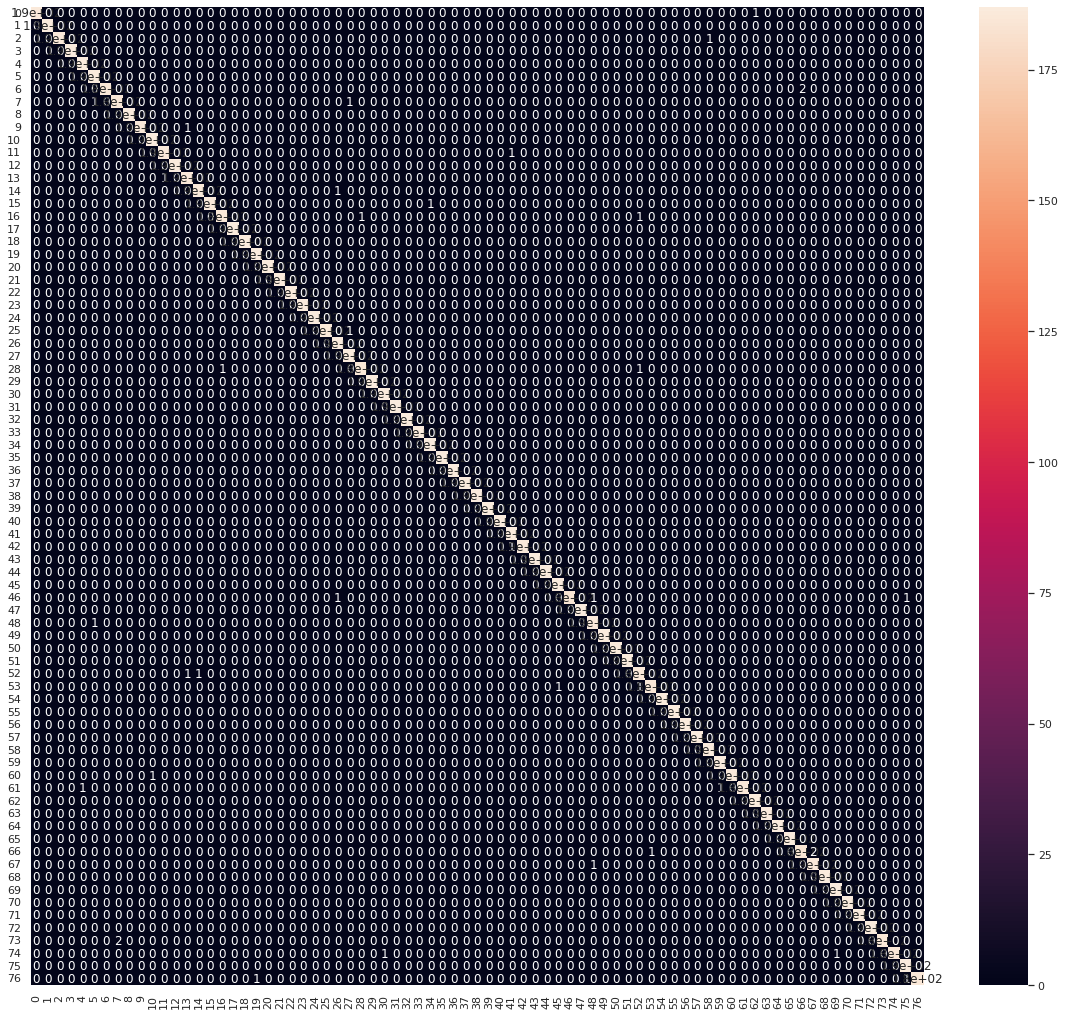

In [63]:
import seaborn as sns

pred = final_model.predict([test_text['input_ids'], test_text['attention_mask']])
cf_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(cf_matrix, annot=True)

In [64]:
eval = final_model.evaluate([test_text['input_ids'], test_text['attention_mask']], test_labels, verbose=2)

450/450 - 49s - loss: 0.2432 - categorical_accuracy: 0.9974


# Conclusions

- Highest achieved accuracy:
    - 89.06% categorical accuracy with downsampled banking77 dataset
    - 93.05% categorical accuracy with unchanged banking77 dataset
    - 99.74% categorical accuracy with upsampled banking77 dataset

- Best results found when:
    - Only the first two layers are frozen (leaving 2 layers with trainable parameters)
    - Only one (densely connected) layer is placed on top of DistilBERT
    - Simple cosine decay learning rate scheduler is used instead of a constant learning rate

The least accurate of the models was the one fine-tuned on the downsampled banking77 dataset. The dataset was reduced from around 10,000 to 2695 - 35 for each class. This was expected to yield relatively low accuracy since so much information from the original dataset had been omitted. The purpose of this model was to take advantage of the quick training time associated with the smaller dataset, meaning debugging and optimising could be done as quickly as possible.

Slightly more accurate than that model was the one fine-tuned on the regular dataset. This model had the benefit of being trained with more information, and so had experience classifying a wider range of inputs, but it had the disadvantage of begin heavily imbalanced. The frequency of most class labels was around 100, with the most frequent label occurring 187 times and the least frequent 35 times. Hence the accuracy was only slightly more than the downsampled dataset model, despite having nearly four times the data on which to train.

Significantly more accurate than both was the model fine-tuned on the upsampled dataset, which had the advantage of as much information as possible as well as a balanced dataset. The upsampled dataset had 14399 entries - 187 for each class.

With dropout added, the final model improved in accuracy from 99.65% to 99.74%, which is almost negligible, but a step in the right direction nonetheless to indicate the effects of adding dropout - making the model more robust (thus more accurate with a never-before-seen test dataset).

# Exploration of the Test Dataset

In [1]:
!pip install datasets
!pip install transformers

import pandas as pd
from datasets import load_dataset

all_data = load_dataset('banking77')
train_data, test_data = pd.DataFrame(all_data['train']), pd.DataFrame(all_data['test'])

     |████████████████████████████████| 270 kB 5.2 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 119 kB 53.8 MB/s 
     |████████████████████████████████| 243 kB 38.4 MB/s 
     |████████████████████████████████| 1.3 MB 39.8 MB/s 
     |████████████████████████████████| 142 kB 50.0 MB/s 
     |████████████████████████████████| 294 kB 57.1 MB/s 
     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 636 kB 40.1 MB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/158k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

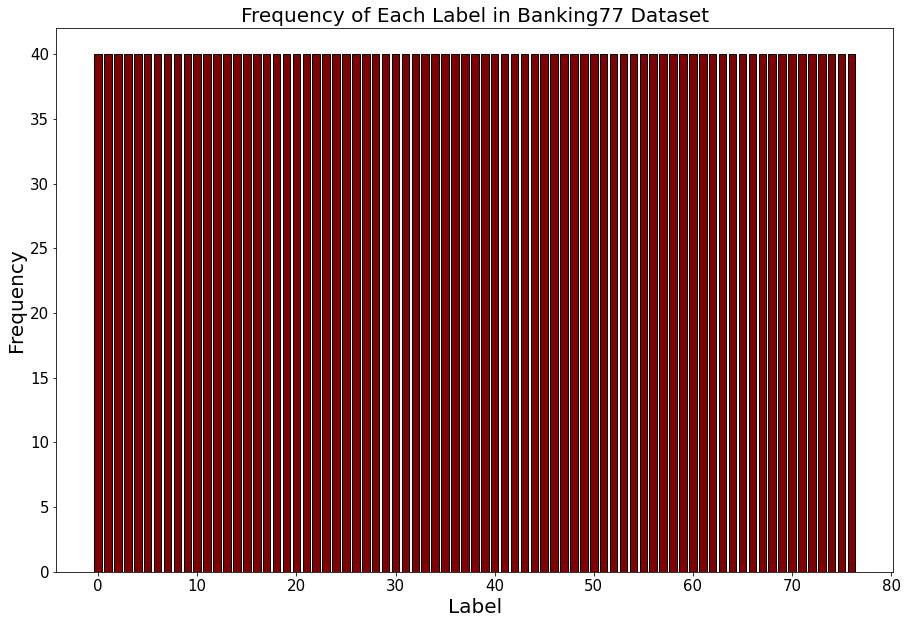

In [2]:
import matplotlib.pyplot as plt

label_counts = list(pd.DataFrame(test_data['label'].value_counts()).sort_index()['label'])
labels = range(0, 77)

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.bar(labels, label_counts, width=0.76, color='maroon', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Banking77 Test Dataset')
plt.show()

### What Does This Mean for Us?
Unfortunately the test dataset is perfectly uniform, undermining some of our conclusions drawn - upsampling/downsampling to produce a balanced dataset is not necessarily a good thing to do per se, it may have only been a good thing to do here because it meant the training dataset matched the shape of the test dataset.

In the real world, training datasets usually have distributions indicative of data that their models will be expected to handle. Thinking about a dataset similar to banking77 used in a real bank for a QA chatbot, certain questions will naturally be more common for customers to ask than others and so there may be more occurrences of such questions in the training dataset. However, this isn't a problem because the question is unlikely to become less popular after training, meaning we expect a similar distribution. Of course, over a long period of time the distribution may change, for example in 10 years time there may be almost no questions about cash and cheques and very many about apple pay, but this is a different matter - the point is that it is natural for training and test datasets to have similar distributions.

### Train a Model and Test it on a Test Dataset With the Same Distribution as Training Dataset
- Use Scikit Learn to split the dataset, keeping the distribution the same either side of the split

In [7]:
!pip install datasets
!pip install transformers

In [8]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

data = load_dataset('banking77')
all_data = pd.DataFrame(data['train']).append(pd.DataFrame(data['test']))

train_text, test_text, train_labels, test_labels = train_test_split(all_data['text'], all_data['label'], test_size=0.20, random_state=42, stratify=all_data['label'])
# stratified train test split

train_data = pd.DataFrame({'text': [], 'label': []})
test_data = pd.DataFrame({'text': [], 'label': []})

train_data['text'] = train_text
train_data['label'] = train_labels
test_data['text'] = test_text
test_data['label'] = test_labels

Using custom data configuration default
Reusing dataset banking77 (/root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

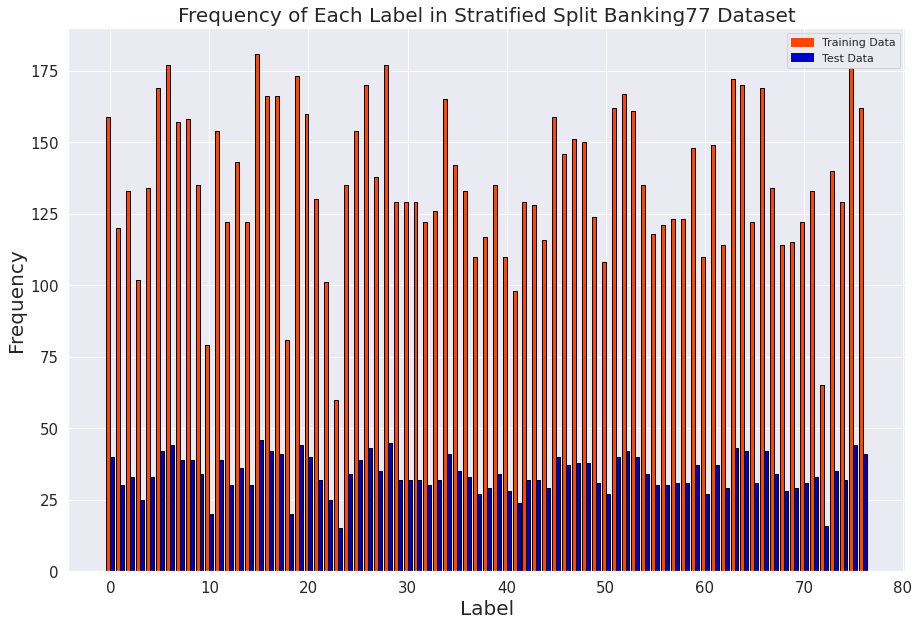

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

labels = range(0, 77)
train_label_counts = list(pd.DataFrame(train_data['label'].value_counts()).sort_index()['label'])
test_label_counts = list(pd.DataFrame(test_data['label'].value_counts()).sort_index()['label'])

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

train_patch = mpatches.Patch(color='orangered', label='Training Data')
test_patch = mpatches.Patch(color='mediumblue', label='Test Data')
plt.legend(handles=[train_patch, test_patch])

plt.bar(labels, train_label_counts, width=-0.4, color='orangered', edgecolor='black', align='edge')
plt.bar(labels, test_label_counts, width=0.4, color='mediumblue', edgecolor='black', align='edge')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Stratified Split Banking77 Dataset')
plt.show()

In [11]:
import tensorflow as tf
from transformers import TFDistilBertModel

train_data = train_data.sample(frac=1, random_state=10)

"""     Set up DistilBERT part of the model     """

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# get distilbert 

input_ids = tf.keras.Input(shape=(98,), name='input_token', dtype='int32')
input_masks = tf.keras.Input(shape=(98,), name='masked_token', dtype='int32')
# configure inputs

dbert_layer = dbert_model(input_ids, attention_mask=input_masks)[0][:,0,:]
# output layer of distilbert to be input to the neural network on top

"""     Set up neural network part of model     """    

dropout = tf.keras.layers.Dropout(0.1)(dbert_layer)
# add some dropout for robustness

output_layer = tf.keras.layers.Dense(
    77, 
    activation='softmax', 
    kernel_regularizer='l2'
    )(dropout)
# output layer, fully connected, with 77 neurons since there are 77 output classes

"""     Apply freezing and compile     """

realistic_model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=output_layer)

for layer in realistic_model.layers[:2]:
    layer.trainable = False

sched_lr = tf.keras.optimizers.schedules.CosineDecay(     # learning rate schedule for Adam optimizer
      initial_learning_rate=0.0001,   # initial learning rate, quite large
      decay_steps=314*10,    # roughly 314 steps per epoch, want it to decay over 10 epochs 
      alpha=0.01      # want minimum learning rate to be alpha*initial_learning_rate
      )

sched_opt = tf.keras.optimizers.Adam(learning_rate=sched_lr)    # 0.0001

realistic_model.compile(
    optimizer=sched_opt, 
    loss='categorical_crossentropy', # categorical crossentropy is to be minimised since we have 77 categories to classify into
    metrics=['categorical_accuracy']  # again, this is a categorical classification task
    )

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [13]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

"""     Tokenize text     """

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_text = tokenizer(
    list(train_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

test_text = tokenizer(
    list(train_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

"""     One hot encode the labels     """

train_labels = tf.keras.utils.to_categorical(train_data['label'])   # pd.get_dummies() also works
test_labels = tf.keras.utils.to_categorical(train_data['label'])

# if using sparse categorical crossentropy, uncomment the following
# train_labels = train_data['label']
# test_labels = test_data['label']

Exception ignored in: <function tqdm.__del__ at 0x7f7171b628c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [14]:
history = realistic_model.fit(
    [train_text['input_ids'], train_text['attention_mask']], 
    train_labels,
    batch_size=30,   # number of input sentences between updating the weights
    epochs=10,   # probs fiddle with this to experiment
    verbose=2,  # want to see more information
    validation_split=0.1    # seems about right
)

Epoch 1/10
314/314 - 100s - loss: 2.4571 - categorical_accuracy: 0.7076 - val_loss: 1.5406 - val_categorical_accuracy: 0.8997
Epoch 2/10
314/314 - 94s - loss: 1.3395 - categorical_accuracy: 0.9316 - val_loss: 1.2833 - val_categorical_accuracy: 0.9169
Epoch 3/10
314/314 - 94s - loss: 1.0080 - categorical_accuracy: 0.9708 - val_loss: 1.1075 - val_categorical_accuracy: 0.9150
Epoch 4/10
314/314 - 94s - loss: 0.7881 - categorical_accuracy: 0.9856 - val_loss: 0.9400 - val_categorical_accuracy: 0.9274
Epoch 5/10
314/314 - 94s - loss: 0.6365 - categorical_accuracy: 0.9937 - val_loss: 0.8268 - val_categorical_accuracy: 0.9293
Epoch 6/10
314/314 - 94s - loss: 0.5320 - categorical_accuracy: 0.9968 - val_loss: 0.7541 - val_categorical_accuracy: 0.9341
Epoch 7/10
314/314 - 94s - loss: 0.4661 - categorical_accuracy: 0.9989 - val_loss: 0.7089 - val_categorical_accuracy: 0.9312
Epoch 8/10
314/314 - 94s - loss: 0.4284 - categorical_accuracy: 0.9990 - val_loss: 0.6786 - val_categorical_accuracy: 0.9379

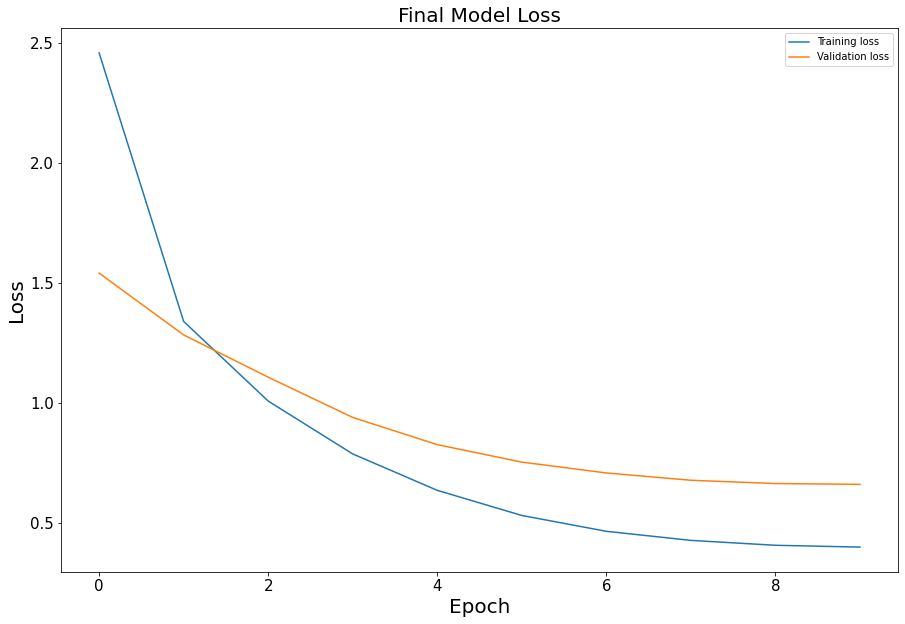

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

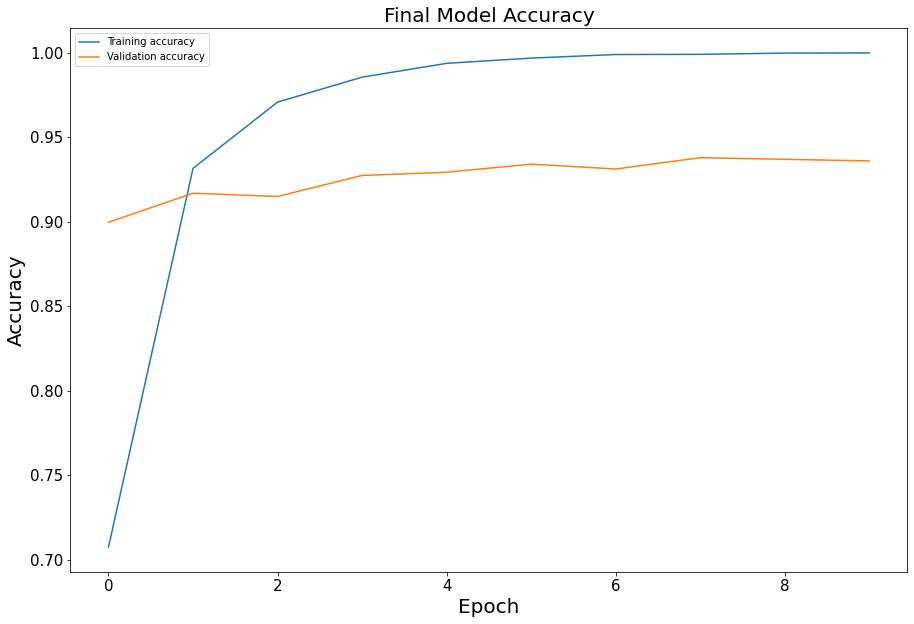

In [16]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

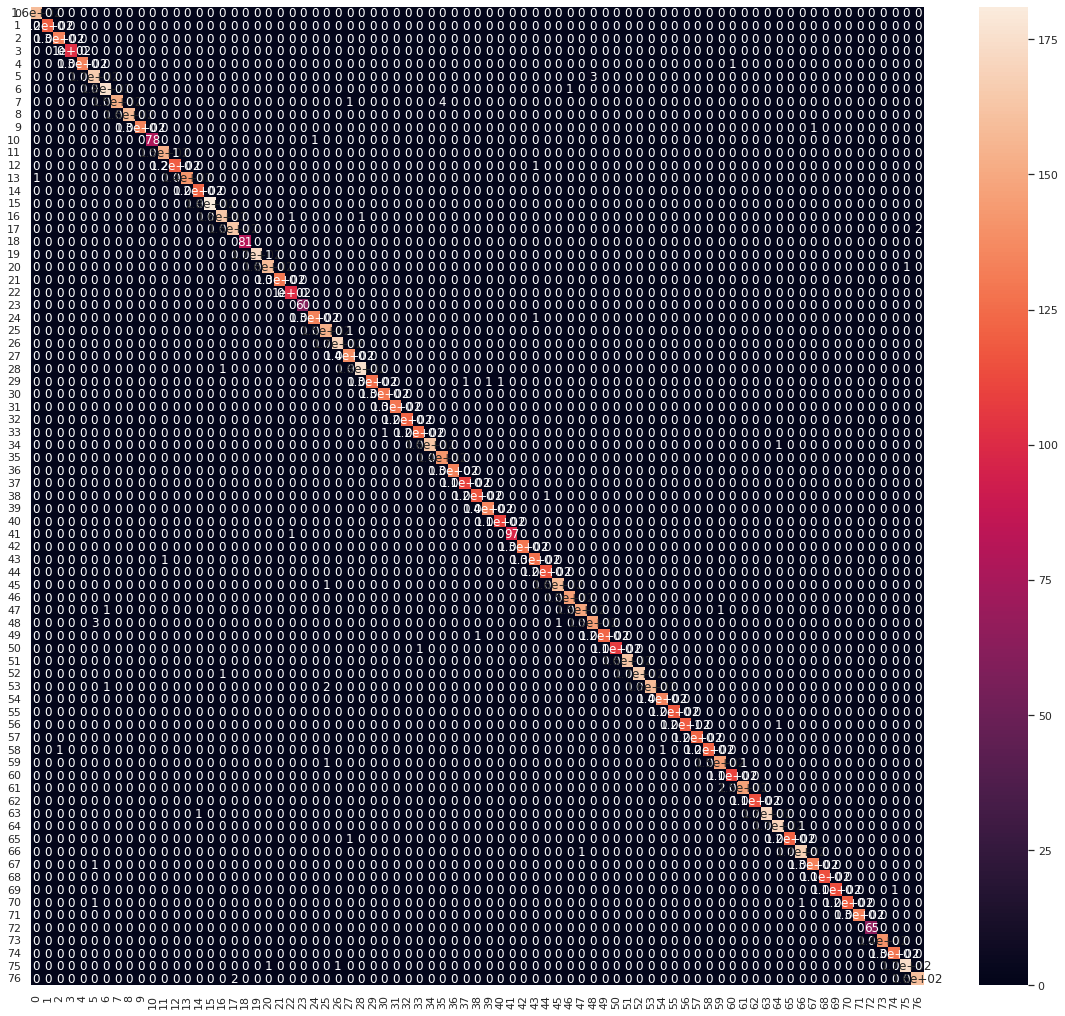

In [18]:
import seaborn as sns

pred = realistic_model.predict([test_text['input_ids'], test_text['attention_mask']])
cf_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(cf_matrix, annot=True)

In [20]:
eval = realistic_model.evaluate([test_text['input_ids'], test_text['attention_mask']], test_labels, verbose=2)

328/328 - 35s - loss: 0.4162 - categorical_accuracy: 0.9936


### Final Thoughts

99.36% accuracy achieved with the 'realistic' model, an accuracy very similar to the 99.74% achieved previously. This shows that the degree to which the training dataset is balanced is not important in itself - rather the similarity in distributions between the training dataset and the data which the model encounters when in use.